# MMSegmentation Tutorial
Welcome to MMSegmentation! 

In this tutorial, we demo
* How to do inference with MMSeg trained weight
* How to train on your own dataset and visualize the results. 

## Install MMSegmentation
This step may take several minutes. 

We use PyTorch 1.10 and CUDA 11.1 for this tutorial. You may install other versions by change the version number in pip install command. 

In [ ]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install PyTorch
#!pip install torch==1.12.0 torchvision --extra-index-url https://download.pytorch.org/whl/cu113
# Install MMCV
!pip install openmim
!mim install mmcv-full

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 5.7 MB/s 
     |████████████████████████████████| 238 kB 56.3 MB/s 
     |████████████████████████████████| 51 kB 8.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.openmmlab.com/mmcv/dist/cu116/torch1.13.0/index.html
     |████████████████████████████████| 46.1 MB 118 kB/s 
     |████████████████████████████████| 190 kB 20.4 MB/s 


In [ ]:
!rm -rf mmsegmentation
!git clone https://github.com/open-mmlab/mmsegmentation.git 
%cd mmsegmentation
!pip install -e .

Cloning into 'mmsegmentation'...
remote: Enumerating objects: 12923, done.
remote: Counting objects: 100% (343/343), done.
remote: Compressing objects: 100% (218/218), done.
remote: Total 12923 (delta 176), reused 234 (delta 124), pack-reused 12580
Receiving objects: 100% (12923/12923), 15.58 MiB | 17.08 MiB/s, done.
Resolving deltas: 100% (9296/9296), done.
/content/mmsegmentation
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/mmsegmentation
  Running setup.py develop for mmsegmentation


In [ ]:
!pwd

/content/mmsegmentation


In [ ]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMSegmentation installation
import mmseg
print(mmseg.__version__)

1.12.0+cu113 True
0.29.1


In [ ]:
cd /content/mmsegmentation

/content/mmsegmentation


## Run Inference with MMSeg trained weight

In [ ]:
!python tools/model_converters/beit2mmseg.py https://dl.fbaipublicfiles.com/mae/pretrain/mae_pretrain_vit_base.pth  pretrain/mae_pretrain_vit_base_mmcls.pth

load checkpoint from http path: https://dl.fbaipublicfiles.com/mae/pretrain/mae_pretrain_vit_base.pth


In [ ]:
#!wget https://dl.fbaipublicfiles.com/mae/pretrain/mae_pretrain_vit_base.pth  -P /content/pretrain

--2022-12-19 18:52:38--  https://dl.fbaipublicfiles.com/mae/pretrain/mae_pretrain_vit_base.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 172.67.9.4, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 343249461 (327M) [binary/octet-stream]
Saving to: ‘/content/pretrain/mae_pretrain_vit_base.pth.5’

mae_pretrain_vit_ba 100%[===================>] 327.35M  21.5MB/s    in 16s     

2022-12-19 18:52:55 (20.4 MB/s) - ‘/content/pretrain/mae_pretrain_vit_base.pth.5’ saved [343249461/343249461]



In [ ]:
pwd

'/content/mmsegmentation'

In [ ]:
%cd /content/mmsegmentation

/content/mmsegmentation


In [ ]:
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
from mmseg.core.evaluation import get_palette

## Train a semantic segmentation model on a new dataset

To train on a customized dataset, the following steps are necessary. 
1. Add a new dataset class. 
2. Create a config file accordingly. 
3. Perform training and evaluation. 

### Add a new dataset

Datasets in MMSegmentation require image and semantic segmentation maps to be placed in folders with the same prefix. To support a new dataset, we may need to modify the original file structure. 

In this tutorial, we give an example of converting the dataset. You may refer to [docs](https://github.com/open-mmlab/mmsegmentation/blob/master/docs/en/tutorials/customize_datasets.md#customize-datasets-by-reorganizing-data) for details about dataset reorganization. 

We use [Stanford Background Dataset](http://dags.stanford.edu/projects/scenedataset.html) as an example. The dataset contains 715 images chosen from existing public datasets [LabelMe](http://labelme.csail.mit.edu), [MSRC](http://research.microsoft.com/en-us/projects/objectclassrecognition), [PASCAL VOC](http://pascallin.ecs.soton.ac.uk/challenges/VOC) and [Geometric Context](http://www.cs.illinois.edu/homes/dhoiem/). Images from these datasets are mainly outdoor scenes, each containing approximately 320-by-240 pixels. 
In this tutorial, we use the region annotations as labels. There are 8 classes in total, i.e. sky, tree, road, grass, water, building, mountain, and foreground object. 

In [ ]:
# download and unzip
#!wget http://dags.stanford.edu/data/iccv09Data.tar.gz -O stanford_background.tar.gz
#!tar xf stanford_background.tar.gz

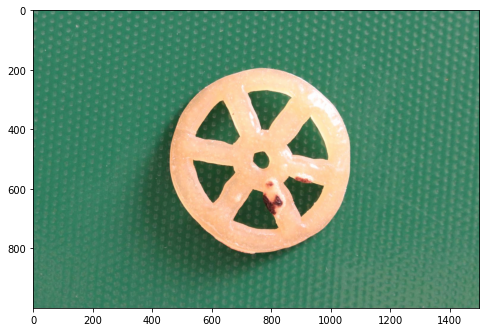

In [ ]:
# Let's take a look at the dataset
import mmcv
import matplotlib.pyplot as plt

img = mmcv.imread('/content/drive/MyDrive/FYP_AD/maeseg/capsules/images/004.JPG')
plt.figure(figsize=(8, 6))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

We need to convert the annotation into semantic map format as an image.

In [ ]:
import os.path as osp
import numpy as np
from PIL import Image
# convert dataset annotation to semantic segmentation map
data_root = '/content/drive/MyDrive/FYP_AD/maeseg/capsules'
img_dir = 'images'
ann_dir = 'labels'
# define class and plaette for better visualization
classes = ('anomalous region' , 'background')
palette = [[255,0,0],[0,0,0]]

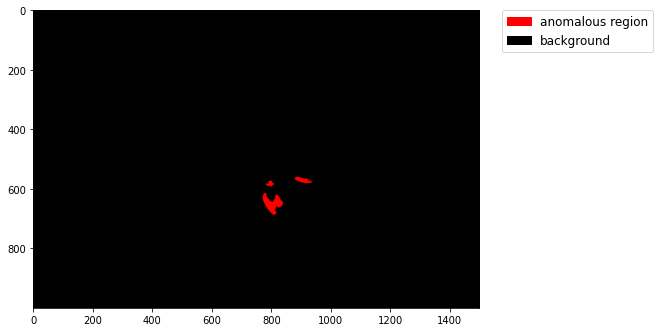

In [ ]:
# Let's take a look at the segmentation map we got
import matplotlib.patches as mpatches
img = Image.open('/content/drive/MyDrive/FYP_AD/maeseg/capsules/labels/004.png')
plt.figure(figsize=(8, 6))
im = plt.imshow(np.array(img.convert('RGB')))

# create a patch (proxy artist) for every color 
patches = [mpatches.Patch(color=np.array(palette[i])/255., 
                          label=classes[i]) for i in range(2)]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
           fontsize='large')

plt.show()

In [ ]:
# split train/val set randomly

split_dir = 'splits'
mmcv.mkdir_or_exist(osp.join(data_root, split_dir))
filename_list = [osp.splitext(filename)[0] for filename in mmcv.scandir(
    osp.join(data_root, ann_dir), suffix='.png')]
with open(osp.join(data_root, split_dir, 'train.txt'), 'w') as f:
  # select first 4/5 as train set
  train_length = int(len(filename_list)*4/5)
  f.writelines(line + '\n' for line in filename_list[:train_length])
with open(osp.join(data_root, split_dir, 'val.txt'), 'w') as f:
  # select last 1/5 as train set
  f.writelines(line + '\n' for line in filename_list[train_length:])
  

After downloading the data, we need to implement `load_annotations` function in the new dataset class `StanfordBackgroundDataset`.

In [ ]:
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset

@DATASETS.register_module()
class VisA(CustomDataset):
  CLASSES = classes
  PALETTE = palette
  def __init__(self, split,**kwargs):
    super().__init__(img_suffix='.JPG', seg_map_suffix='.png', 
                     split=split, reduce_zero_label=False, **kwargs)
    assert osp.exists(self.img_dir) and self.split is not None


    

### Create a config file
In the next step, we need to modify the config for the training. To accelerate the process, we finetune the model from trained weights.

In [ ]:
from mmcv import Config
cfg = Config.fromfile('configs/mae/upernet_mae-base_fp16_8x2_512x512_160k_ade20k.py')
#cfg = Configs.fromfile('configs/mae/upernet_mae-base_fp16_512x512_160k_ade20k_ms.py')

Since the given config is used to train PSPNet on the cityscapes dataset, we need to modify it accordingly for our new dataset.  

In [ ]:
from mmseg.apis import set_random_seed
from mmseg.utils import get_device

# Since we use only one GPU, BN is used instead of SyncBN
cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.norm_cfg1 = dict(type='BN', eps=1e-06)
cfg.model.backbone.norm_cfg = cfg.norm_cfg1
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg
# modify num classes of the model in decode/auxiliary head

cfg.model.decode_head.num_classes = 4
cfg.model.auxiliary_head.num_classes = 4

# Modify dataset type and path
cfg.dataset_type = 'VisA'
cfg.data_root = data_root

cfg.data.samples_per_gpu = 4
cfg.data.workers_per_gpu=4

cfg.img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
cfg.crop_size = (512, 512)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(1500, 1000), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(1500, 1000),
        # img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]


cfg.data.train.type = cfg.dataset_type
cfg.data.train.data_root = cfg.data_root
cfg.data.train.img_dir = img_dir
cfg.data.train.ann_dir = ann_dir
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = '/content/drive/MyDrive/FYP_AD/maeseg/capsules/splits/train.txt'

cfg.data.val.type = cfg.dataset_type
cfg.data.val.data_root = cfg.data_root
cfg.data.val.img_dir = img_dir
cfg.data.val.ann_dir = ann_dir
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = '/content/drive/MyDrive/FYP_AD/maeseg/capsules/splits/val.txt'

cfg.data.test.type = cfg.dataset_type
cfg.data.test.data_root = cfg.data_root
cfg.data.test.img_dir = img_dir
cfg.data.test.ann_dir = ann_dir
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = '/content/drive/MyDrive/FYP_AD/maeseg/capsules/splits/val.txt'

# We can still use the pre-trained Mask RCNN model though we do not need to
# use the mask branch
cfg.load_from = '/content/mmsegmentation/pretrain/mae_pretrain_vit_base_mmcls.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './work_dirs/tutorial'

cfg.runner.max_iters = 100
cfg.log_config.interval = 10
cfg.evaluation.interval = 20
cfg.checkpoint_config.interval = 20

# Set seed to facitate reproducing the result
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)
cfg.device = get_device()

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained='./pretrain/mae_pretrain_vit_base_mmcls.pth',
    backbone=dict(
        type='MAE',
        img_size=(512, 512),
        patch_size=16,
        in_channels=3,
        embed_dims=768,
        num_layers=12,
        num_heads=12,
        mlp_ratio=4,
        out_indices=[3, 5, 7, 11],
        attn_drop_rate=0.0,
        drop_path_rate=0.1,
        norm_cfg=dict(type='BN', eps=1e-06),
        act_cfg=dict(type='GELU'),
        norm_eval=False,
        init_values=1.0),
    neck=dict(type='Feature2Pyramid', embed_dim=768, rescales=[4, 2, 1, 0.5]),
    decode_head=dict(
        type='UPerHead',
        in_channels=[768, 768, 768, 768],
        in_index=[0, 1, 2, 3],
        pool_scales=(1, 2, 3, 6),
        channels=768,
        dropout_ratio=0.1,
        num_classes=4,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
   

### Train and Evaluation

In [ ]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor


# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_segmentor(cfg.model)
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True, 
                meta=dict())

2022-12-20 05:28:34,389 - mmseg - INFO - Loaded 48 images
/content/mmsegmentation/mmseg/models/backbones/beit.py:303: UserWarning: DeprecationWarning: pretrained is deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is deprecated, '
/usr/local/lib/python3.8/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/content/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader wil

ValueError: ignored

Inference with trained model

In [ ]:
!pwd

In [ ]:
img = mmcv.imread('iccv09Data/images/6000124.jpg')

model.cfg = cfg
result = inference_segmentor(model, img)
plt.figure(figsize=(8, 6))
show_result_pyplot(model, img, result, palette)